# ML-Fundamentals - Neural Networks - Exercise: Convolution Layer

## Table of Contents
* [Requirements](#Requirements) 
  * [Knowledge](#Knowledge) 
  * [Modules](#Python-Modules) 
  * [Data](#Data)
* [Convolution and Maxpool Layer](#Convolution-and-Maxpool-Layer)
  * [Todo: Kernels](#Kernels)
  * [Todo: Convolution](#Convolution)
  * [Todo: Pooling](#Pooling)
  * [Todo: Experiments](#Experiments)

# Requirements

## Knowledge
By now you should be familiar with the convolution operation, but you may want to repeat some information again. Following source are recommended:
- [1163050 Lecture Slides](http://home.htw-berlin.de/~voigtb/content/slides/1163150_lecture_05.pdf)
- [cs231n ConvNets Lecture Notes](http://cs231n.github.io/convolutional-networks/)
- [Colah's Blog](http://colah.github.io/posts/2014-07-Understanding-Convolutions/)

## Python-Modules

In [1]:
# third party
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import scipy.signal 
from tqdm import tqdm

## Data
For the exercise i used the 'Photo of the Day' (6.6.2018) from Unsplash.com by Adrian Trinkaus. You can change it at will.

grayscale shape: (660, 660)
rgb shape: (660, 660, 3)


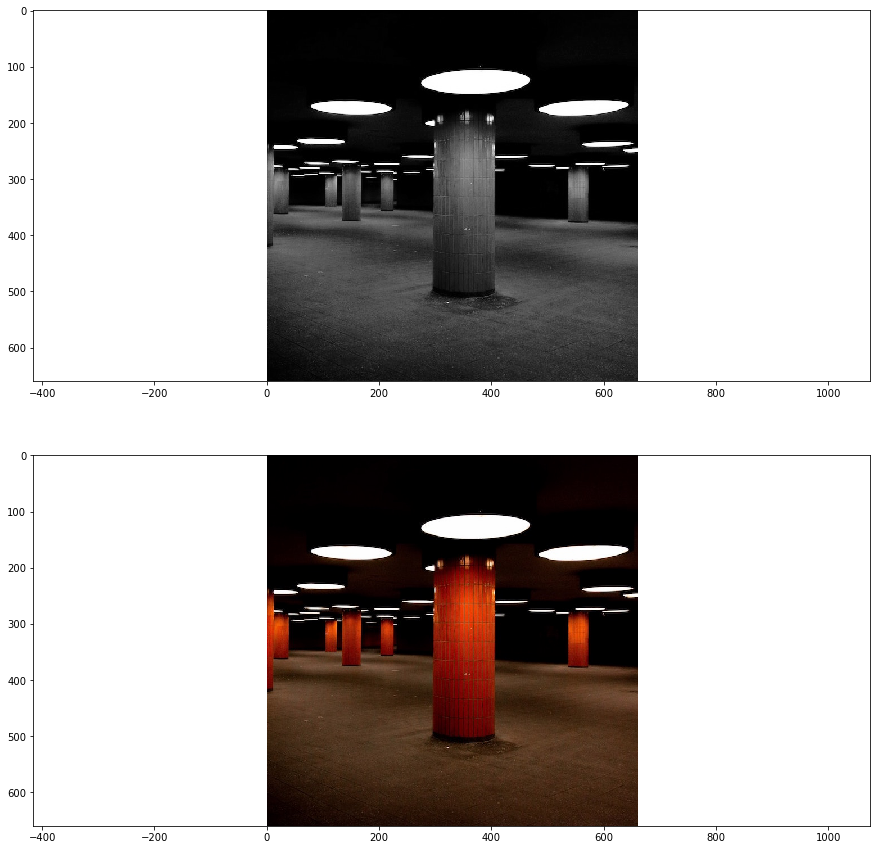

In [2]:
# Open an image
img = Image.open('pics/berlin_adrian-trinkaus.jpg')
# Convert it to greyscale and RGB
img_gry = img.convert('L')
img_rgb = img.convert('RGB')
 
# Create a numpy array with dimensions (height, width, channel)
# and squash all values into interval [0,1]
img_gry = np.asarray(img_gry)/256.
img_rgb = np.asarray(img_rgb)/256.

# Print array shapes
print('grayscale shape:', img_gry.shape)
print('rgb shape:', img_rgb.shape)

# Example plot
fig, (ax1, ax2) = plt.subplots(2, sharey=True,figsize=(15,15))
ax1.imshow(img_gry, cmap="Greys_r")
ax2.imshow(img_rgb)
plt.show()

# Convolution and Maxpool Layer

## Kernels 
**(2)**
Cause we do not learn the filters during the exercise we will need some for your experiments. Some Filters are given and you should create at least two more. Do a small research about 'image processing filters' and pick what you like. Remember that your Kernels need to have the same depth as your input. You may consider this issue during your implementation of the convolution operation. 

In [10]:
# typical edge detection filter
class Kernels:
    def __init__(self):
        self.edge_detector_1_2d = np.array([[0., 1., 0.],[1., -4., 1.],[0., 1., 0.]])
        self.edge_detector_2_2d = np.array([[1., 0., -1.],[0., 0., 0.],[-1., 0., 1.]])
        self.edge_detector_3_2d = np.array([[-1., -1., -1.],[-1., 8., -1.],[-1., -1., -1.]])
        self.sobel_2d = np.array([[1.,2.,1.],[0.,0.,0],[-1.,-2.,-1.]])
        self.gauss_2d = self.blur()
        self.sharpen_2d = np.array([[0., -1., 0.],[-1., 5., -1.],[0., -1., 0.]])
        self.box_blur_2d = 1/9 * np.array([[1., 1., 1.],[1., 1., 1.],[1., 1., 1.]])
        self.identity_2d = np.array([[0., 0., 0.],[0., 1., 0.],[0., 0., 0.]])
        
    def blur(self):
        gauss_1d = scipy.signal.get_window(('gaussian',1.),15)
        gauss_2d = np.outer(gauss_1d,gauss_1d)
        return gauss_2d/gauss_2d.sum()

## Convolution
**(5)** 
Create a `Conv` class that implements a (naive) convolution operation on _one_ image at the time. Do not use any module, your goal is to get a better understanding for a 2d-conv operation. If your input has more as one channel apply on each the same conv-operation. Document your code and follow the  specification. After your implementation, give a statement about the runtime of your algorithm based on the $O$ notation.

Fragen 
* Was macht man mit ungeraden Paddings (z.B. P = 1.5)? 
* drüfen wir nicht mal numpy als modul verwenden?
* Wenn es mehr channel gibt zb. dim = (4,4,3) soll dann die outut dim = (.,.,3) oder wi (.,.,1) sein?

In [14]:
class Conv:
    def __init__(self, image_dim, kernel, stride=1, padding=True, verbose=None):
        """ 
        Args:
            image_dim: dimension of the squared image 
            kernel: a filter for the convulution
            stride: step size with which the kernel slides over the image
            padding: if set zero padding will be applied to keep image dimensions
            verbose: if set additional information will be printed, e.g., input and output dimensions
        """
        self.image_dim = image_dim
        self.padding = int(((image_dim[0]-1)*stride-image_dim[0]+kernel.shape[0])/2 if padding else 0)
        self.output_dim = (int((image_dim[0]-kernel.shape[0]+2*self.padding)/stride+1), int((image_dim[1]-kernel.shape[0]+2*self.padding)/stride+1))
        self.kernel = kernel
        self.kernel_dim = kernel.shape[0]
        self.stride = stride
        self.verbose = verbose
        
    def forward(self, image):
        """ Executes a convolution on the given image with init params  
        
        Args:
            image (ndarray): squared image 
        
        Returns:    
            ndarray: activation map
        """
        output = np.zeros(self.output_dim)
        image, self.image_dim = self.add_padding_to_image(image)
        
        for h_out, h_in in enumerate(tqdm(range(0,self.image_dim[0]-self.kernel_dim+1,self.stride))):
            for w_out, w_in in enumerate(range(0,self.image_dim[1]-self.kernel_dim+1,self.stride)):
                
                output_per_depth = None
                
                if len(self.image_dim) == 3:
                    output_per_depth = np.zeros(self.image_dim[2])
                    
                    for d in range(self.image_dim[2]):
                        output_per_depth[d] = np.sum(self.kernel * image[h_in:h_in+self.kernel_dim, w_in:w_in+self.kernel_dim, d])
                else:
                    output_per_depth = np.array([np.sum(self.kernel * image[h_in:h_in+self.kernel_dim, w_in:w_in+self.kernel_dim])])
                    
                output[h_out,w_out] = np.sum(output_per_depth)
                    
        return output
    
    def add_padding_to_image(self, image):
    
        if self.padding == 0:
            return image, image.shape
        
        padded_image_dim = list(self.image_dim)
        
        for i in [0,1]:
            padded_image_dim[i] = padded_image_dim[i] + 2 * self.padding
            
        padded_image_dim = tuple(padded_image_dim)
        
        padded_image = np.zeros(padded_image_dim)
        
        padded_image[self.padding:-self.padding, self.padding:-self.padding] = image
    
        return padded_image, padded_image.shape

100%|██████████| 660/660 [00:31<00:00, 20.88it/s]


result shape: (660, 660)


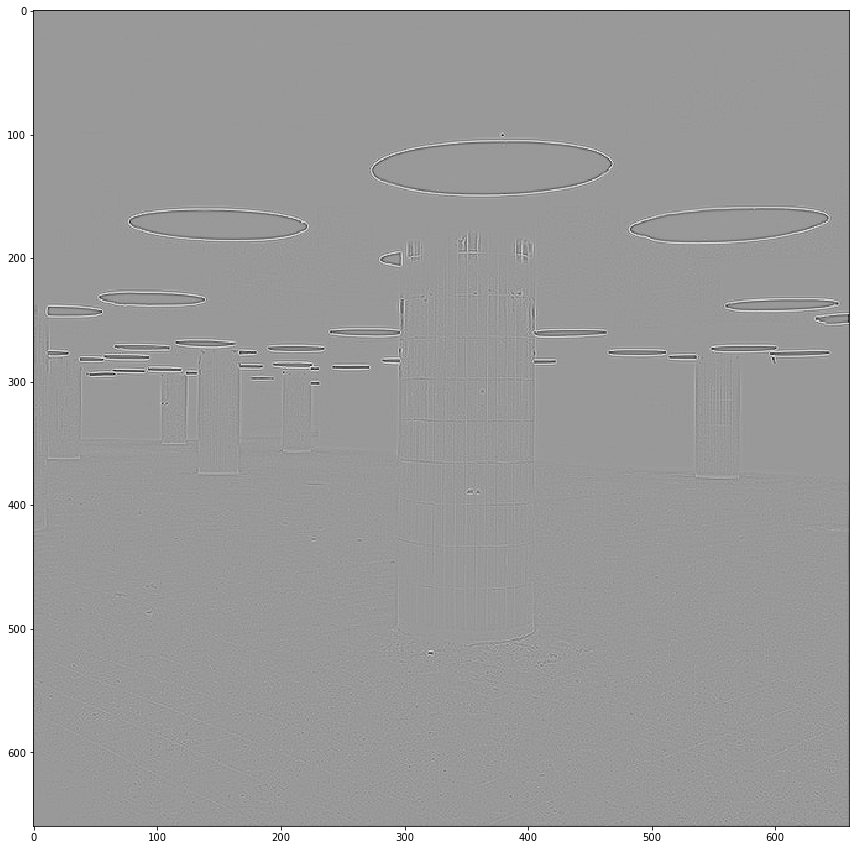

In [17]:
conv = Conv(img_rgb.shape, Kernels().edge_detector_1_2d)
result = conv.forward(image)

print('result shape:', result.shape)

# Example plot
fig, (ax1) = plt.subplots(1, sharey=True,figsize=(15,15))
ax1.imshow(result, cmap="Greys_r")
plt.show()

## Pooling
**(2)** 
Create a `Pooling` class that implements the pooling operation with different functions (max, sum, mean) on a given image. Document your code and follow the specification.

In [ ]:
class Pooling():
    def __init__(self, image_dim, pooling_function=None, pooling_size=2, stride=2, verbose=None):
        """ 
        Args:
            image_dim: dimension of the squared image 
            pooling_function: defines the pooling operator 'max' (default), 'mean' or 'sum'
            poolig_size: size of one axis of the squared pooling filter
            stride: step size with which the filter slides over the image
            verbose: if set additional information will be printed, e.g., input and output dimensions
        """
        raise NotImplementedError("This is your duty")
        
    def forward(self, image):
        """ Executes pooling on the given image with init params  
        
        Args:
            image (ndarray): squared image 
        
        Returns:    
            ndarray: activation map
        """
        return NotImplementedError("This is your duty")        

## Experiments
**(3)**
Use the data (you may want to try some more images) and different kernel to do some experiments with your implementations. Plot results of convolution operations and compare them. What happens if you stack several convolution operations? What are the differences between the pooling functions? 